# **4 leptons analysis**   

This notebook presents an analysis of simulated high-energy collision data targeting four-lepton final states at the Future Circular Collider - electron-positron mode (FCC-ee), focusing on Higgs boson decays into two Z bosons (one on-shell and one off-shell), which subsequently decay into four leptons, most often four muons. The four-lepton final state is often referred to as the "golden channel" due to its low background contamination and excellent reconstruction potential in detectors. 

From a physics standpoint, this process allows precision measurements of the Higgs properties, such as mass, couplings, and branching fractions, and serves as a probe for possible deviations from the Standard Model. However, the signal competes with several irreducible and reducible background processes: Standard Model production of ZZ pairs, WW pairs, Zqq, and other Higgs decay channels (H->bb, cc,ττ,WW,gg,Za) that may mimic the four-lepton final state.

<img src="images_for_documented/signal.jpg" style="height:300px; width:auto;"> <img src="images_for_documented/backgrounds.jpg" style="height:300px; width:auto;">

The notebook uses a modular analysis pipeline based on the Coffea framework in combination with Awkward Arrays and Dask, enabling scalable data handling and histogramming. The workflow begins with the definition of datasets corresponding to both signal and background samples, including their cross sections and integrated luminosities. A set of physics observables is then reconstructed, such as invariant masses of lepton pairs, four-lepton invariant mass, visible energy, missing momentum, and isolation variables. These are analyzed across successive selection stages (cutflows) designed to enhance the signal-to-background ratio.

The analysis produces histograms and summary tables of event yields for each process, comparing simulated predictions under realistic detector assumptions. The results illustrate the reconstruction of the Higgs boson peak in the four-lepton channel and provide a framework to evaluate the performance of event selections, backgrounds, and overall sensitivity at the FCC-ee.

Do this in the terminal before running the notebook:   
$ conda install boost-histogram==1.6.1

Import all libraries and helper functions:   

In [1]:
import os, re
import copy
import glob
import importlib
import yaml
import vector
import hist

import awkward as ak
import numpy as np
import pandas as pd
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import defaultdict
from matplotlib.ticker import AutoMinorLocator
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from coffea import processor, util
from coffea.analysis_tools import PackedSelection, Cutflow
from coffea.dataset_tools import apply_to_fileset, max_chunks, preprocess
from coffea.nanoevents import BaseSchema, FCC
from coffea.util import load

In [2]:
vector.register_awkward()
pgb = ProgressBar()
pgb.register()

# **Config**     

Set up the configuration parameters for the analysis run.   

In [3]:
## which data schema to use
use_schema = "FCC"
schema_version = "pre-edm4hep1"

## chunks for dataset processing control
runner_chunksize = 1000
runner_chunks = 1

## output
output_path = "Batch"
output_file = "4leptons.coffea"
plot_path = 'outputs/plots/'

## input data location
input_path = output_path+"/"

Define the process configuration dictionary: it stores the collider, campaign, detector setup, integrated luminosity, process, event generator, energy, and a list of signal and background datasets with fractions and cross sections to be analyzed. The fractions (1 * reduction_factor) of events to use from each dataset - downscale the number of events processed. 

In [4]:
reduction_factor = 0.000000001
ecm = 240.0 ## collision energy \sqrt(s) in GeV
process = {
    'collider': 'FCCee',
    'campaign': 'winter2023',
    'detector': 'IDEA',
    'intLumi': 10.80e+06, ## integrated luminosity in pb-1
    'ana_tex': 'e^{+}e^{-} \\rightarrow ZH \\rightarrow 4\\mu+ X',
    'delphesVersion': '3.4.2',
    'energy': ecm, #in GeV
    'samples': {
        # Signal
        'wzp6_ee_qqH_HZZ_llll_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.00003777},
        'wzp6_ee_nunuH_HZZ_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.00122},
        # Backgrounds
        'p8_ee_Zqq_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 52.6539},
        'p8_ee_ZZ_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 1.35899},
        'p8_ee_WW_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 16.4385},
        'wzp6_ee_tautauH_HWW_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.001453},
        'wzp6_ee_ccH_HWW_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.005023},
        'wzp6_ee_bbH_HWW_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.00645},
        'wzp6_ee_mumuH_HWW_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.001456},
        'wzp6_ee_mumuH_Hcc_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.0001956},
        'wzp6_ee_mumuH_Hbb_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.00394},
        'wzp6_ee_mumuH_Hgg_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.0005538},
        'wzp6_ee_mumuH_HZa_ecm240': {'fraction': 1 * reduction_factor, 'cross_section': 0.00001037}
    }
}
fractions = {name: info['fraction'] for name, info in process['samples'].items()}
cross_sections = {name: info['cross_section'] for name, info in process['samples'].items()}
all_datasets = list(process['samples'].keys())

Define the set of plots to be generated and their properties.   
Convert this dictionary into a pandas DataFrame for easier access when plotting.   

In [5]:
plots = {
    'selectedmuons_p':{'name':'selected_muons_p','title':'$\\mu_p$ [GeV]','xlabel':'$p_T$ [GeV]','ylabel':'Events','bins':250,'xmin':0,'xmax':250},

    'fourmuons_mass':{'name':'fourMuons_mass','title':'$M_{4\\mu}$ [GeV]','xlabel':'$Mass$ [GeV]','ylabel':'Events','bins':50,'xmin':0,'xmax':250},
    'fourmuons_pmin':{'name':'fourMuons_pmin','title':'$(P_{4\\mu})_{min}$ [GeV]','xlabel':'$p_{min}$ [GeV]','ylabel':'Events','bins':20,'xmin':0,'xmax':100},

    'Z_res_mass':{'name':'zll_mass','title':'On-shell $M_{\\mu\\mu}$ [GeV]','xlabel':'$Mass$ [GeV]','ylabel':'Events','bins':50,'xmin':0,'xmax':250},
    'Z_non_res_mass':{'name':'non_res_Z_m','title':'Off-shell $M_{\\mu\\mu}$ [GeV]','xlabel':'$Mass$ [GeV]','ylabel':'Events','bins':50,'xmin':0,'xmax':250},

    'vis_e_woMuons':{'name':'vis_e_other_particles','title':'Visible Energy excluding muons [GeV]','xlabel':'$E$ [GeV]','ylabel':'Events','bins':50,'xmin':0,'xmax':250},
    'iso_least_isolated_muon':{'name':'fourMuons_min_iso','title':'iso(least isolated muon)','xlabel':'iso','ylabel':'Events','bins':50,'xmin':0,'xmax':20},
    'missing_p':{'name':'pmiss','title':'missing p [GeV]','xlabel':'$p^{miss}$ [GeV]','ylabel':'Events','bins':50,'xmin':0,'xmax':250},
    'cos_theta_miss':{'name':'cosTheta_miss','title':'Cos(Theta_miss)','xlabel':'$cos_{miss}\\theta$','ylabel':'Events','bins':100,'xmin':0,'xmax':1},
}
plot_props = pd.DataFrame(plots)

Plotting variables:

In [6]:
stack = [True, False] ## stacked/unstacked
log = [True, False] ## linear/log scale
formats = ['png']
req_plots = ['selectedmuons_p','fourmuons_mass','fourmuons_pmin','Z_res_mass','Z_non_res_mass','vis_e_woMuons','iso_least_isolated_muon','missing_p','cos_theta_miss']
req_hists = {
        #Signal
        "qqH_HZZ":{"type":'Signal',"datasets":['wzp6_ee_qqH_HZZ_llll_ecm240'],"color":'red'},
        "nunuH_HZZ":{"type":'Signal',"datasets":['wzp6_ee_nunuH_HZZ_ecm240'],"color":'orange'},
        #Background
        "ZZ":{"type":'Background',"datasets":['p8_ee_ZZ_ecm240'],"color":'blue'},
        "Zqq":{"type":'Background',"datasets":['p8_ee_Zqq_ecm240'],"color":'yellow'},
        "mumuH_Hjj":{"type":'Background',"datasets":['wzp6_ee_mumuH_Hbb_ecm240','wzp6_ee_mumuH_Hcc_ecm240','wzp6_ee_mumuH_Hgg_ecm240',],"color":'cyan'},
        "WW":{"type":'Background',"datasets":['p8_ee_WW_ecm240'],"color":'gray'},
        "HWW":{"type":'Background',"datasets":['wzp6_ee_mumuH_HWW_ecm240','wzp6_ee_bbH_HWW_ecm240','wzp6_ee_tautauH_HWW_ecm240','wzp6_ee_ccH_HWW_ecm240'],"color":'teal'},
        "mumuH_HZa":{"type":'Background',"datasets":['wzp6_ee_mumuH_HZa_ecm240'],"color":'green'},

}
selections = ['sel0','sel1','sel2','sel3','sel4','sel5','sel6'] ## list of selection stages used for cutflow analysis 
# Extra cosmetics
yield_table_scale = 0.7 # reduce font sizes in yield table by this factor, so that they fit in the figure area
legend_location = (0.64, 0.64) # Coordinate of the bottom left corner of the legend wrt to the plot area
FCC_text_location = (0.30,1.02) # Coordinate of the bottom left corner of the FCC text wrt to the plot area
custom_mc_order = ['ZZ', 'Zqq', 'WW', 'mumuH_Hjj', 'HWW', 'mumuH_HZa'] # From top to bottom
Reverse_legend_labels = False # Reverse legend order without changing the stack order

# **Functions**   

**resonanceBuilder_mass** builds dilepton candidates and selects oppositely charged pairs whose invariant mass is closest to a given resonance mass.   
**Input**: resonance_mass (float, target mass), leptons (awkward array with momentum, charge, and index), and optional MC-related arguments.   
**Output**: an awkward array of dilepton candidates (with summed four-momentum, charge, and original lepton indices), sorted by closeness to the target resonance mass.   

In [7]:
def resonanceBuilder_mass(resonance_mass=None, use_MC_Kinematics=False, leptons=None, MCRecoAssociations=None, ReconstructedParticles=None, MCParticles=None):
    if leptons is None:
        raise AttributeError("No leptons passed")
    # Create all the combinations
    combs = ak.combinations(leptons,2)
    # Get dileptons
    lep1 , lep2 = ak.unzip(combs)
    di_lep = lep1 + lep2 # This process drops any other field except 4 momentum fields

    di_lep["charge"] =  lep1.charge + lep2.charge
    di_lep["l1_index"] = lep1.index
    di_lep["l2_index"] = lep2.index

    # Choose oppositely charged leptons
    di_lep = di_lep[di_lep.charge == 0]

    # Sort by closest mass to the resonance value
    sort_mask = ak.argsort(abs(resonance_mass-di_lep.mass), axis=1)
    Reso = di_lep[sort_mask]

    return Reso
    return Reso, used_lep1, used_lep2

**getTwoHighestPMuons** selects the two highest-momentum muons in each event, requiring them to have opposite charge.   
**Input**: muons (awkward array with momentum p and charge).   
**Output**: (muon1, muon2, mask) where muon1 and muon2 are the leading opposite-charge muons (or None if not found), and mask is a boolean per event indicating whether a valid opposite-charge pair exists.   

In [8]:
def getTwoHighestPMuons(muons):
    # if not ak.all(ak.num(muons, axis=1) > 1 ):
    # raise IndexError("Need at least two particles!")
    sorted_muons_p = ak.argsort(muons.p, ascending=False)
    sorted_muons = muons[sorted_muons_p]

    # First particle is always selected, if the second one has the opposite charge, then its accepted otherwise we move on to the third and so on
    # Interestingly, this type of operation is non trivial in an array format
    first_muon, other_muons = sorted_muons[:, 0:1], sorted_muons[:, 1:]

    # prepare before cartesian : replace none with []
    first_muon = ak.fill_none(first_muon, [], axis=0)
    other_muons = ak.fill_none(other_muons, [], axis=0)
    # All combinations
    all_comb = ak.cartesian([first_muon, other_muons])
    l1, l2 = ak.unzip(all_comb)
    charge_mask = l1.charge!= l2.charge
    l1 = l1[charge_mask]
    l2 = l2[charge_mask]
    
    at_least_one_opp_charged = ak.sum(charge_mask, axis=1) > 0 # is an event selection
    
    return ak.firsts(l1), ak.firsts(l2), at_least_one_opp_charged

**sum_all** computes the total four-momentum of a collection of particles.   
**Input**: array_of_lv (awkward array of Lorentz vectors with fields px, py, pz, E).   
**Output**: an awkward array with summed four-momentum components, returned as a Momentum4D object.   

In [9]:
def sum_all(array_of_lv):
    out = ak.zip(
        {
            "px":ak.sum(array_of_lv.px , axis=1),
            "py":ak.sum(array_of_lv.py , axis=1),
            "pz":ak.sum(array_of_lv.pz , axis=1),
            "E":ak.sum(array_of_lv.E , axis=1)
        },
        with_name="Momemtum4D"
    )
    return out

**coneIsolation** computes the isolation of a particle by summing momenta of nearby charged and neutral particles within a ΔR cone.   
**Input**: particle (awkward array with momentum p and four-vector info), rest_of_the_particles (awkward array with charge and momentum), min_dr (float, default=0.0), max_dr (float, default=0.4).   
**Output**: isolation ratio = (sum of nearby particle momenta) / (particle momentum).   
**Refer**: https://github.com/delphes/delphes/blob/master/modules/Isolation.cc#L154   

In [10]:
def coneIsolation(particle, rest_of_the_particles, min_dr=0.0 , max_dr=0.4):
    neutral_particles = ak.mask(rest_of_the_particles, rest_of_the_particles.charge == 0)
    charged_particles = ak.mask(rest_of_the_particles, rest_of_the_particles.charge != 0)

    n_combs = ak.cartesian((particle,neutral_particles[:,np.newaxis]), axis=1)
    n1,n2 = ak.unzip(n_combs)
    c_combs = ak.cartesian((particle,charged_particles[:,np.newaxis]), axis=1)
    c1,c2 = ak.unzip(c_combs)

    n_angle = n1.deltaangle(n2)
    c_angle = c1.deltaangle(c2)

    n_angle_mask = (n_angle < max_dr) & (n_angle >= min_dr)
    c_angle_mask = (c_angle < max_dr) & (c_angle >= min_dr)

    filtered_neutral = n2[n_angle_mask]
    filtered_charged = c2[c_angle_mask]

    sumNeutral = ak.sum(filtered_neutral.p, axis=2)
    sumCharged = ak.sum(filtered_charged.p, axis=2)

    total_sum = sumNeutral + sumCharged

    ratio = total_sum / particle.p

    return ratio

**recoilBuilder** computes the recoil four-momentum against a given system.   
**Input**: vec (awkward array with four-vector fields px, py, pz, E), ecm (float, center-of-mass energy).   
**Output**: an awkward array Momentum4D representing the recoil vector (-vec in momentum, ecm - E in energy).   

In [11]:
def recoilBuilder(vec, ecm):
    Recoil = ak.zip({"px":0.0-vec.px,"py":0.0-vec.py,"pz":0.0-vec.pz,"E":ecm-vec.E},with_name="Momentum4D")
    return Recoil

**remove** removes elements from an array based on specified indices.   
**Input**: array (awkward array), idx (awkward array containing indices of elements to remove).   
**Output**: a filtered awkward array with the specified elements removed.   

In [12]:
def remove(array, idx):
    index = idx.index
    all_index = ak.local_index(array,axis=1)
    i,a = ak.unzip(ak.cartesian([index[:,np.newaxis] ,all_index], nested=True))
    c = a == i
    d = ak.firsts(c)
    s = ak.sum(d, axis=2)
    kl = s == 1
    return array[~kl]

**get_hist** creates a histogram for a given variable.   
**Input**: name (string, used to fetch histogram properties from plot_props), var (array-like data to fill), flatten (bool, default=False; if True, flattens nested arrays).   
**Output**: a filled histogram object (hist.Hist).   

In [13]:
def get_hist(name, var, process_dataset, flatten=False):
    
    # name is physical variable: mass, momentum, etc.
    # var is that variable data with selections/cuts - ready to be filled in histogram of 'name'
    # process is interactions, each histogram should be a merge of all processes
    
    props = plot_props[name]
    if flatten:
        var = ak.flatten(var, axis=None)
    var = var[~ak.is_none(var, axis=0)]
    if isinstance(var, ak.Array):
        var = ak.to_numpy(var)
    myhist = (
        hist.Hist.new
            .Reg(props.bins, props.xmin, props.xmax, name="observable", label=props.xlabel)
            .StrCat(all_datasets, name="dataset", label="Dataset", growth=True)
            .Double()
        )
    myhist.fill(
        observable=var,
        dataset=process_dataset,
    )
    
    # print(process_dataset)
    print(myhist)
    # print(len(var))
    
    return myhist

**create_mask** creates a boolean mask where elements of a and b are not equal to c.   
**Input**: a, b, c (arrays or values of the same shape).   
**Output**: boolean array where True indicates both a and b differ from c.   

In [14]:
def create_mask(a, b, c):
    mask1 = a != c
    mask2 = b != c
    mask = mask1 & mask2
    return mask

**get_schema** imports and returns a particle physics event schema.   
**Input**: use_schema (str, "BaseSchema" or "FCC", default="BaseSchema"), schema_version (str, default="latest", only used for FCC).   
**Output**: tuple (schema_handler, schema, schema_name) containing the handler class, the schema object, and a descriptive name.   

In [15]:
def get_schema(use_schema: str = "BaseSchema", schema_version: str = "latest"):
    if use_schema == "BaseSchema":
        module_name = "coffea.nanoevents"
        schema_caller = "BaseSchema"
    elif use_schema == "FCC":
        module_name = "coffea.nanoevents"
        schema_caller = "FCC"
    else:
        raise ValueError(f"The requested schema '{use_schema}' is not available.")

    module = importlib.import_module(module_name)
    schema_handler = getattr(module, schema_caller, None)

    if schema_handler is None:
        raise ImportError(f"Could not import schema handler '{schema_caller}' from '{module_name}'.")

    if use_schema == "FCC":
        schema = schema_handler.get_schema(schema_version)
        schema_name = f"FCC.get_schema('{schema_version}')"
        if schema is None:
            raise ValueError(f"The requested version '{schema_version}' for schema '{use_schema}' is not available.")
    else:
        schema = schema_handler
        schema_name = "BaseSchema"

    return schema_handler, schema, schema_name

**load_yaml_fileinfo** loads yaml configuration files for a given process’s filesets.   
**Input**: process (dict with keys collider, campaign, detector, and samples).   
**Output**: dictionary mapping each sample name to its loaded yaml content.   

In [16]:
def load_yaml_fileinfo(process):
    onlinesystem_path = '/cvmfs/fcc.cern.ch'
    localsystem_path = "../../filesets/"
    path = '/'.join(
        [
         'FCCDicts',
         'yaml',
         process['collider'],
         process['campaign'],
         process['detector']
        ])
    if os.path.exists(onlinesystem_path):
        print(f'Connected to {onlinesystem_path}')
        filesystem_path = onlinesystem_path
    else:
        print(onlinesystem_path+' is not available.\nTrying to find local copies of the yaml files ...')
        filesystem_path = localsystem_path
    yaml_dict = {}
    for sample in process['samples']:
        full_path = '/'.join([filesystem_path, path, sample, 'merge.yaml'])
        try :
            with open(full_path) as f:
                dict = yaml.safe_load(f)
            print('Loaded : '+full_path)
        except:
            raise FileNotFoundError(f'Could not find yaml files at {filesystem_path}')
        yaml_dict[sample] = dict
    return yaml_dict

**assign_events** finds the index in a cumulative sum array corresponding to a target number of events.   
**Input**: cumsum (1D array of cumulative sums), needed_events (int or float, target number of events).   
**Output**: index in cumsum where the cumulative sum first reaches or exceeds needed_events.   

In [17]:
def assign_events(cumsum, needed_events):
    if needed_events > cumsum[-1]:
        return len(cumsum)-1
    diff = cumsum - needed_events
    return np.argwhere(diff >= 0)[0][0]

**get_fileset** selects a fraction of files from a yaml-defined dataset and returns them in a Dask-compatible format.   
**Input**: yaml_dict (dict of dataset metadata), fraction (dict mapping process names to fraction of events to select), skipbadfiles (bool, default=True), redirector (str, optional path prefix).   
**Output**: dictionary mapping each process key to its selected files and associated 'events'.   

In [18]:
def get_fileset(yaml_dict, fractions, skipbadfiles=True, redirector=''):
    output_fileset_dictionary = {}
    print('_________Loading fileset__________')
    for key in yaml_dict.keys():
        output_fileset_dictionary[key] = {}
        # nbad = yaml_dict[key]['merge']['nbad']
        # ndone = yaml_dict[key]['merge']['ndone']
        nevents = yaml_dict[key]['merge']['nevents']
        outdir = yaml_dict[key]['merge']['outdir']
        outfiles = yaml_dict[key]['merge']['outfiles']
        outfilesbad = yaml_dict[key]['merge']['outfilesbad']
        proc = yaml_dict[key]['merge']['process']
        # size = yaml_dict[key]['merge']['size']
        # sumofweights = yaml_dict[key]['merge']['sumofweights']
        out = np.array(outfiles)
        bad = np.array(outfilesbad)

        # Remove bad files
        if (bad.size != 0) & skipbadfiles :
            filenames_bad = bad[:,0]
            y = out
            for row in range(out.shape[0]) :
                file = out[row,0]
                if file in filenames_bad:
                    y = np.delete(y , (row), axis=0)
            out = y

        filenames = out[:,0]
        file_events = out[:,1].astype('int32')
        cumulative_events = np.cumsum(file_events)

        frac = fractions[proc]
        needed_events = frac*nevents

        # get closest value and index to the needed events
        # index = np.abs(cumulative_events - needed_events).argmin()
        #
        # FCCAnalyses uses the ceiling value instead of closest value
        # Eg. if we need 341 events and cumsum is [...300 , 400 ...] , then 400 events are choosen, even though 341 events is more closer to 300 events in comparison to 400
        # To get this ceiling value, we could get the most positive value from the cumulative_events - needed_events difference
        index = assign_events(cumulative_events, needed_events)

        assigned_events = cumulative_events[index]
        assigned_files = filenames[:index+1]

        # Summary
        print('----------------------------------')
        print(f'----------{key}---------')
        print('----------------------------------')
        print(f'Total available events = {nevents}')
        print(f'Fraction needed = {frac}')
        print(f'Needed events = {needed_events}')
        print(f'Assigned events = {assigned_events}')
        print(f'Number of files = {len(assigned_files)}')
        print('Files:')

        # At the same time get the dictionary
        fileset_by_key = {}
        for file in assigned_files:
            print(f'\t {redirector+outdir+file}')
            fileset_by_key[redirector+outdir+file] = 'events'
        output_fileset_dictionary[key]['files'] = fileset_by_key
    return output_fileset_dictionary

**break_into_many** splits a fileset into n roughly equal smaller filesets.   
**Input**: input_fileset (dict of files organized by dataset), n (int, number of splits).   
**Output**: list of n filesets, each containing a subset of the original files.   

In [19]:
def break_into_many(input_fileset,n):
    # Create an indexed fileset
    fileset = copy.deepcopy(input_fileset)
    index = 0
    for dataset in input_fileset.keys():
        for filename,treename in input_fileset[dataset]['files'].items():
            fileset[dataset]['files'][filename] = {'treename': treename, 'index': index}
            index += 1

    # Split the array as required
    nfiles = sum([len(fileset[dataset]['files']) for dataset in fileset.keys()])
    if n == 0 :
        return [input_fileset]
    elif n > 0 and n <= index:
        index_split = np.array_split(np.arange(nfiles),n)
    else :
        raise ValueError(f'Allowed values of n between 0 and {index}')

    # Choose the required indices for each split
    raw = [copy.deepcopy(input_fileset) for i in range(n)]
    for f in range(n):
        for dataset in fileset.keys():
            for event in fileset[dataset]['files'].keys():
                if not fileset[dataset]['files'][event]['index'] in index_split[f]:
                    del raw[f][dataset]['files'][event]

    #remove empty fields
    out = copy.deepcopy(raw)
    for f in range(n):
        for dataset in raw[f].keys():
            if len(raw[f][dataset]['files']) == 0 :
                del out[f][dataset]

    return out

**accumulate** recursively merges a list of dictionaries, supporting: numeric summation, list concatenation, set union, histogram addition (from `hist`), nested dictionaries, key exceptions (preserve first).   
**Input**: dicts (list of dictionaries).   
**Output**: single dictionary with merged values: numeric values summed, lists concatenated, sets unioned, histograms added, nested dictionaries merged, and specified exceptions preserved.   

In [20]:
def accumulate(dicts):
    try:
        from hist import Hist
    except ImportError:
        Hist = None  # Skip if hist is not available

    exception_list = {'Labels'}
    grouped = defaultdict(list)

    for d in dicts:
        for k, v in d.items():
            grouped[k].append(v)

    outdict = {}

    for key, values in grouped.items():
        first = values[0]

        if key in exception_list:
            outdict[key] = first
        elif all(isinstance(v, dict) for v in values):
            outdict[key] = accumulate(values)
        elif all(isinstance(v, list) for v in values):
            outdict[key] = sum(values, [])  # concatenate
        elif all(isinstance(v, set) for v in values):
            result = set()
            for v in values:
                result |= v
            outdict[key] = result
        elif Hist and all(isinstance(v, Hist) for v in values):
            total = values[0]
            for v in values[1:]:
                total += v
            outdict[key] = total
        elif all(isinstance(v, Number) for v in values):
            outdict[key] = sum(values)
        else:
             # Mixed types or strings — keep the first
            outdict[key] = first

    return outdict

**get_xsec_scale** computes the scale factor for a dataset based on its cross section, number of generated events, and target luminosity.   
**Input**: dataset (str, dataset name), raw_events (int, number of generated events), Luminosity (float, target integrated luminosity).   
**Output**: scale factor (float).   

In [21]:
def get_xsec_scale(dataset, raw_events, Luminosity):
    xsec = cross_sections[dataset] #in per picobarn
    if raw_events > 0:
        sf = (xsec*Luminosity)/raw_events
    else :
        raise ValueError('Raw events less than of equal to zero!')
    return float(sf)

**hist_sorter** reorders histograms, labels, and colors according to a preferred order for plotting.   
**Input**: preferred_order (list of labels in desired order), unsorted_hists (list of histogram objects), unsorted_labels (list of labels), unsorted_colors (list of colors).   
**Output**: tuple (sorted_hists, sorted_labels, sorted_colors) sorted according to preferred_order.   

In [22]:
def hist_sorter(preferred_order, unsorted_hists, unsorted_labels, unsorted_colors):
    sorted_hists, sorted_labels, sorted_colors = [], [], []
    for l in preferred_order[::-1]:
        pos = unsorted_labels.index(l)
        sorted_hists.append(unsorted_hists[pos])
        sorted_labels.append(unsorted_labels[pos])
        sorted_colors.append(unsorted_colors[pos])
    return sorted_hists, sorted_labels, sorted_colors

**yield_plot** creates a yield summary plot as a styled table for multiple datasets.   
**Input**: name (str, output file base name), title (str, plot title), keys (list of dataset keys), scaled (list of scaled yield dictionaries), unscaled (list of unscaled yield dictionaries), formats (list of output file formats, e.g., ['png', 'pdf']), path (str, output directory), plot_width, plot_height (optional, figure size).   
**Output**: none (saves plot files).   

In [23]:
def yield_plot(name, title, keys, scaled, unscaled, formats, path, plot_width=8, plot_height=8):
    fig, ax = plt.subplots(figsize=(plot_width,plot_height))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.25, 1.02, 'FCC Analyses: FCC-ee Simulation (Delphes)', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.92, 1.02, '$\\sqrt{s} = '+str(process['energy'])+' GeV$', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.10, 0.95, process['collider'], fontsize=14, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.10, 0.88,'Delphes Version: '+ process['delphesVersion'], fontsize=14, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.10, 0.81, 'Signal : $'+process['ana_tex']+'$', fontsize=14, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.10, 0.74, '$L = '+str(process['intLumi']/1e6)+' ab^{-1}$', fontsize=14, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    table_scale = globals().get("yield_table_scale", 1)
    print("table_scale", table_scale)
    level, linespacing = 0.72, 0.05
    for scale,obs in zip(['UNSCALED','SCALED'],[unscaled,scaled]):
        ax.text(0.02, level, scale, weight='bold', fontsize=int(13*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        level -= linespacing*table_scale
        ax.text(0.02, level, 'Sample', weight='bold', fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.30, level, 'Type', weight='bold', fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.49, level, 'Raw', weight='bold', fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.68, level, 'Yield', weight='bold', fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.87, level, 'Yield %', weight='bold', fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        for i in range(len(keys)):
            print(f"obs[{i}] keys:", obs[i].keys())

            datasets = req_hists[list(keys)[i]]['datasets']
            Type = req_hists[list(keys)[i]]['type']
            color = req_hists[list(keys)[i]]['color']
            yield_text = str(round(obs[i]['Cutflow'].values()[-1],2))
            raw_text = str(round(obs[i]['Cutflow'].values()[0],2))
            percentage = str(round(obs[i]['Cutflow'].values()[-1]*100/obs[i]['Cutflow'].values()[0],2))
            level -= linespacing*table_scale
            ax.text(0.02, level, list(keys)[i], fontsize=int(10*table_scale), color=color,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            ax.text(0.30, level, Type, color=color, fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            ax.text(0.49, level, raw_text, color=color, fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            ax.text(0.68, level, yield_text, color=color, fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            ax.text(0.87, level, percentage, color=color, fontsize=int(12*table_scale), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        level -= 2*linespacing*table_scale

    ax.set_title(title,pad=25,  fontsize= "15", color="#192655")
    for format in formats :
        filename = name+'.'+format
        full_name = path+filename
        fig.savefig(full_name,dpi=240);
        print(filename, " saved at ", path)
    plt.close()

**cuts_table** creates and saves a visual table of cut labels for an analysis.   
**Input**: name (str, output file base name), title (str, plot title), labels (list of cut labels), formats (list of output file formats, e.g., ['png', 'pdf']), path (str, output directory).   
**Output**: none (saves plot files).   

In [24]:
def cuts_table(name, title, labels, formats, path):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.text(0.25, 1.02, 'FCC Analyses: FCC-ee Simulation (Delphes)', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.92, 1.02, '$\\sqrt{s} = '+str(process['energy'])+' GeV$', fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    level, linespacing = 0.90, 0.05
    ax.text(0.02, level, 'Cut Order', weight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.30, level, 'Label', weight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    for i in range(len(labels)):
        level -= linespacing
        ax.text(0.02, level, str(i), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.30, level, labels[i],fontsize=12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    level -= 2*linespacing

    ax.set_title(title,pad=25,  fontsize= "15", color="#192655")
    for format in formats :
        filename = name+'.'+format
        full_name = path+filename
        fig.savefig(full_name,dpi=240);
        print(filename, " saved at ", path)
    plt.close()

**makeplot** creates a single kinematic histogram on a given Matplotlib axis.   
**Input**: fig, ax (Matplotlib figure and axis objects), hist (data to plot), name (str, plot name), title (str, plot title), label (str, dataset label), xlabel, ylabel (str, axis labels), bins (int), xmin, xmax (plot range), log (bool, log scale on y-axis), stack (bool, stack histograms), color (str or color), histtype (str, e.g., 'step'), xticks (int, optional), cutflow_mode (bool, optional).   
**Output**: none (plots directly).   

In [25]:
def makeplot(props, fig, ax, hist, label, log, stack, color, histtype, xticks=10, cutflow_mode=False):
    if len(hist) != 0 :
        hep.histplot(
            hist,
            yerr=0,
            histtype=histtype,
            label=label,
            color=color,
            alpha=0.8,
            stack=stack,
            edgecolor='black',
            linewidth=1,
            # sort='label',
            ax=ax
        )

    ax.text(*globals().get("FCC_text_location", (0.27, 1.02,)), 'FCC Analyses: FCC-ee Simulation (Delphes)', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(*globals().get("sqrt_s_text_location", (0.92, 1.02)), f'$\\sqrt{{s}} = {process['energy']} GeV$', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    if  cutflow_mode:
        ax.set_ylabel(props.ylabel)
    else:
        per_bin = '/'+str((props.xmax-props.xmin)/props.bins)
        ax.set_ylabel(props.ylabel+per_bin+' [GeV]')
        plt.xlim([props.xmin,props.xmax])
        plt.xticks(np.linspace(props.xmin,props.xmax,xticks+1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_xlabel(props.xlabel)

    if log :
        ax.set_yscale('log')
        plt.tick_params(axis='y', which='minor')
    else:
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.set_title(props.title, pad=25,  fontsize= "15", color="#192655")

**generate_plots** and **process_group** processes multiple datasets to create yield, cutflow, and kinematic plots for a set of selections.   
**Input**: input_dict (dict of datasets with cutflows and histograms), req_hists (dict specifying datasets, types, and colors), req_plots (list of histogram names to plot), selections (list of selection names), stack (list of booleans for stacked/unstacked plotting), log (list of booleans for linear/log scale), formats (list of output file formats), path (str, output directory), plotprops (plot styling properties).   
**Output**: none (saves plots and tables).   

In [26]:
def process_group(key, sel, group_type, req_hists, input_dict, process):
    print(f'-->Type: {group_type}')
    label = key
    datasets = req_hists[key]['datasets']
    color = req_hists[key]['color']
    hists, unscaled_hists = [], []
    
    # print(type(input_dict[sel]['cutflow']))
    # print(input_dict[sel]['cutflow'])
    
    cutflow_hist = input_dict[sel]['cutflow']['Cutflow']
    cut_labels   = input_dict[sel]['cutflow']['Labels']

    # onecut, cutflow_hist, cut_labels = input_dict[sel]['cutflow']
    # cut_labels   = input_dict[sel]['cutflow']['Labels']

    # cutflow_dict = dict(input_dict[sel]['cutflow'])
    # cutflow_hist = cutflow_dict['Cutflow']
    # cut_labels   = cutflow_dict['Labels']
    
    cutflow_values = cutflow_hist.values()
    Raw_Events = cutflow_values[0]
    Hist_dict = input_dict[sel]['histograms']

    scaled_hist = copy.deepcopy(Hist_dict)
    unscaled_hist = copy.deepcopy(Hist_dict)
    
    for i in datasets:
        print(f'-->RawEvents for {i}: {Raw_Events}')
        xsec_scale_factor = get_xsec_scale(i, Raw_Events, process['intLumi'])
        print(f'-->xsec_scale for {i} = {xsec_scale_factor}')

        for name, hist_obj in scaled_hist.items():
            if name != "Cutflow":
                hist_obj[{"dataset": i}] *= xsec_scale_factor

        scaled_hist["Cutflow"] = xsec_scale_factor * cutflow_hist
        unscaled_hist["Cutflow"] = cutflow_hist
    
    hists.append(scaled_hist)
    unscaled_hists.append(unscaled_hist)

    # print("Scaled Cutflow:", scaled_hist.get("Cutflow"))

    return label, datasets, color, accumulate(hists), accumulate(unscaled_hists), cut_labels, cutflow_values


def generate_plots(input_dict, req_hists, req_plots, selections, stack, log, formats, path, plotprops):
    for sel in selections:
        # if sel!='sel0':
        #     break
        print('_________________________________________________________________')
        print('---------------------','Selection:', sel ,'---------------------')
        plot_path_selection = path+sel+'/'
        if not os.path.exists(plot_path_selection):
            os.makedirs(plot_path_selection)

        #Get hist array for different backgrounds
        label_list, label_list_signal = [], []
        dataset_list, dataset_list_signal = [], []
        color_list, color_list_signal = [], []
        hist_list, hist_list_signal = [], []
        unscaled_hist_list, unscaled_hist_list_signal = [], []

        cut_labels, cutflow_values = None, None
        
        for key in req_hists:
            print('-------------------------------------------------------------------')
            print(f"Key: {key}            Sample:{req_hists[key]['datasets']} ")
            print('-------------------------------------------------------------------')

            group_type = req_hists[key]['type']
            if group_type in ['Signal', 'Background']:
                label, datasets, color, hists, unscaled_hists, cut_labels, cutflow_values = process_group(
                    key, sel, group_type, req_hists, input_dict, process
                )

                if group_type == 'Signal':
                    label_list_signal.append(label)
                    dataset_list_signal.append(datasets)
                    color_list_signal.append(color)
                    hist_list_signal.append(hists)
                    unscaled_hist_list_signal.append(unscaled_hists)
                else:
                    label_list.append(label)
                    dataset_list.append(datasets)
                    color_list.append(color)
                    hist_list.append(hists)
                    unscaled_hist_list.append(unscaled_hists)
            else:
                raise TypeError('Unrecognised type in req_hists')

        # Make Cut table
        print('---------------------------------------------------------------')
        print('Cuts Table : Info about the cuts')
        print('---------------------------------------------------------------')
        cuts_table(
            name='Cuts_table',
            title=f'{sel} cuts',
            labels=cut_labels,
            formats=formats,
            path=plot_path_selection
        )
        print('---------------------------------------------------------------')

        #Make Yield Plots
        print('---------------------------------------------------------------')
        print('Yield : Unscaled  and Scaled')
        print('---------------------------------------------------------------')

        # print("DEBUG Yield input - scaled keys:")
        # for idx, h in enumerate(hist_list_signal+hist_list):
            # print(idx, h.keys())
        
        # print("DEBUG Yield input - unscaled keys:")
        # for idx, h in enumerate(unscaled_hist_list_signal+unscaled_hist_list):
            # print(idx, h.keys())

        
        yield_plot(
            name='Yield',
            title=f'{sel} Yield',
            keys=req_hists.keys(),
            scaled=hist_list_signal+hist_list,
            unscaled=unscaled_hist_list_signal+unscaled_hist_list,
            formats=formats,
            path=plot_path_selection,
            plot_width=12
        )
        print('---------------------------------------------------------------')

        # Add cutflow to plot_props
        xticks = np.arange(len(cutflow_values))
        plotprops = plotprops.assign(Cutflow = ['Cutflow',sel+' Cutflow','Cut Order','Events',len(xticks)+1,xticks[0],xticks[-1]])

        # Start plotting
        for hist_name in req_plots+['Cutflow']:
            hist = [hists[hist_name] for hists in hist_list]
            n_bkgs = len(hist)
            hist_signal = [hists[hist_name] for hists in hist_list_signal]
            n_sig = len(hist_signal)
            cutflow_mode=False
            if hist_name =='Cutflow':
                cutflow_mode=True

            print(hist_name, ' : ', plotprops[hist_name].title)
            print('---------------------------------------------------------------')
            for log_mode in log :
                for stack_mode in stack:
                    fig, ax = plt.subplots(figsize=(8,8))
                    order = globals().get("custom_mc_order", None)
                    if not order is None:
                        ordered_hist, ordered_label_list, ordered_color_list = hist_sorter(order, hist, label_list, color_list)
                    else:
                        ordered_hist, ordered_label_list, ordered_color_list = hist, label_list, color_list

                    #Backgrounds
                    makeplot(
                        props=plotprops[hist_name],
                        fig=fig,
                        ax=ax,
                        hist=ordered_hist,
                        label=ordered_label_list,
                        log=log_mode,
                        stack=True, #Always stack backgrounds
                        color=ordered_color_list,
                        histtype='fill',
                        cutflow_mode=cutflow_mode,
                        xticks=8
                    )
                    #Signal
                    stop_plotting_signal = False
                    if stack_mode and n_bkgs != 0 and n_sig != 0:
                        sigl_hist = [h+sum(hist) for h in hist_signal] #Manual stacking because independent stacking is not supported in mplhep
                    elif n_sig != 0 :
                        sigl_hist = hist_signal
                    else:
                        stop_plotting_signal = True

                    if not stop_plotting_signal:

                        hep.histplot(
                            sigl_hist,
                            color=color_list_signal,
                            label=label_list_signal,
                            histtype='step',
                            stack=False, #overridden by stack_mode bool
                            linewidth=1,
                            ax=ax
                        )
                    fig.legend(prop={"size":10},loc= globals().get("legend_location", (0.74,0.74)), reverse=globals().get("Reverse_legend_labels", False) )

                    if log_mode :
                        log_mode_text = 'log'
                    else :
                        log_mode_text = 'linear'

                    if stack_mode :
                        stack_mode_text = 'stacked'
                    else :
                        stack_mode_text = 'unstacked'
                    for format in formats :
                        filename = plotprops[hist_name].name+'_'+log_mode_text+'_'+stack_mode_text+'.'+format
                        full_name = plot_path_selection+filename
                        fig.savefig(full_name,dpi=240);
                        # print(filename, " saved at ", plot_path_selection)
                    plt.close()
            print('-------------------------------------------------------------------')
        print('_____________________________________________________________________\n')

# **Processor**     

Perform event selection for the _H → ZZ* → 4μ_ channel. 
Apply physics cuts, reconstruct Z boson candidates, calculate relevant kinematic variables, produce histograms, and generate cutflow tables.

In [27]:
class Fourleptons(processor.ProcessorABC):
    def __init__(self, *args, **kwargs):
        pass

    def process(self,events):


        process_dataset = events.metadata["dataset"]
        # print(process_dataset)
        ## Create a Packed Selection to store boolean masks for events passing each cut.
        ## This allows later combination of cuts and generation of cutflow tables.
        cut = PackedSelection()

        ## ----------------------------
        ## MUON SELECTION
        ## ----------------------------

        ## Extract muon candidates from the reconstructed particle collection.
        ## events.Muonidx0.index gives indices of muons in ReconstructedParticles.
        Muons = events.ReconstructedParticles[events.Muonidx0.index]
        ## Store the muon's index for later reference when matching/removing.
        Muons["index"] = events.Muonidx0.index
        ## Apply a basic p > 2 GeV momentum cut on each muon.
        sel_muon = Muons.p > 2.0
        ## Mask out muons failing the p > 2 cut.
        selected_muons_p = ak.mask(Muons, sel_muon)

        ## ----------------------------
        ## REQUIRE AT LEAST 4 MUONS
        ## ----------------------------

        ## Count non-None muons per event; require > 3 (4 or more).
        at_least_4_muons = ak.num(ak.drop_none(selected_muons_p), axis=1) > 3
        ## Mask out events failing the >3 muon requirement.
        selected_muons = ak.mask(selected_muons_p, at_least_4_muons)
        
        ## ----------------------------
        ## BUILD ON-SHELL Z CANDIDATE
        ## ----------------------------

        ## Use resonanceBuilder_mass to form lepton pairs and select the one closest to 91.2 GeV (Z boson mass).
        Z = resonanceBuilder_mass(resonance_mass=91.2, use_MC_Kinematics=False, leptons=selected_muons)

        ## Keep only the best Z candidate per event.
        zll = ak.firsts(Z)
        ## Extract the two muons (l1, l2) making up this on-shell Z.
        l1 = ak.firsts(selected_muons[selected_muons.index == zll.l1_index])
        l2 = ak.firsts(selected_muons[selected_muons.index == zll.l2_index])
        
        ## ----------------------------
        ## BUILD OFF-SHELL Z CANDIDATE
        ## ----------------------------

        ## Remove the muons already used for the on-shell Z from the pool.
        mask = create_mask(zll.l1_index, zll.l2_index, selected_muons.index)
        rest_of_muons = selected_muons[mask]

        ## From the remaining muons, choose the two with the highest momentum.
        ## c_mask - make sure there are 3rd and 4th muons and they have opposite charge
        m1, m2, c_mask = getTwoHighestPMuons(rest_of_muons)

        ## Form the off-shell Z candidate from these two muons.
        non_res_Z = m1 + m2
        ## Compute the opening angle between these two muons.
        non_res_Z_angle = m1.deltaangle(m2)

        ## ----------------------------
        ## COLLECT ALL FOUR MUONS
        ## ----------------------------

        ## Combine all four muons into a single awkward array: 
        ## - On-shell Z muons (l1, l2)
        ## - Off-shell Z muons (m1, m2)
        fourMuons_collected = ak.concatenate(
            (
                ak.mask(l1,c_mask)[:, np.newaxis],
                ak.mask(l2,c_mask)[:, np.newaxis],
                m1[:, np.newaxis],
                m2[:, np.newaxis]
            ),
            axis=1
        )
        ## Keep only events that truly have all four muons after masking.
        fourMuons_collected = ak.mask(fourMuons_collected, ak.num(fourMuons_collected, axis=1) > 3)
        ## Combine both Z candidates into one 4-muon system (4-vector sum).
        fourMuons = ak.mask(zll, c_mask) + non_res_Z
        
        ## Minimum momentum among the four muons — used for a cut.
        fourMuons_pmin = ak.min(fourMuons_collected.p, axis=1)
        #print('fourMuons_pmin: ', fourMuons_pmin.head())

        ## ----------------------------
        ## REST OF EVENT CONTENT
        ## ----------------------------

        ## All reconstructed particles in events with >3 muons.
        chosen_reco_4_mu = ak.mask(events.ReconstructedParticles, at_least_4_muons)
        ## Apply additional mask from Z candidate building.
        chosen_reco = ak.mask(chosen_reco_4_mu,c_mask)
        #print('chosen_reco: ', chosen_reco.head() )

        ## Remove the four selected muons from the event.
        rest_of_particles = remove(chosen_reco, fourMuons_collected)
        ## Sum the 4-vectors of all non-muon particles (visible energy excluding muons).
        all_others = sum_all(rest_of_particles)
        #print('all_others: ', all_others.head())

        ## Compute recoil 4-vector against the visible system (used for missing energy).
        Emiss = recoilBuilder(sum_all(chosen_reco), ecm=ecm)
        pmiss = Emiss.E ## magnitude of missing momentum
        #print('pmiss: ', pmiss.head())

        ## ----------------------------
        ## ISOLATION VARIABLES
        ## ----------------------------

        ## Compute cone-based isolation for each muon in the event.
        ## Here, max_dr=0.523599 rad ≈ 30 degrees.
        fourMuons_iso = coneIsolation(fourMuons_collected, rest_of_particles, min_dr=0.0, max_dr=0.523599)
        #print('fourMuons_iso: ', fourMuons_iso.head())
        ## Take the largest isolation value among the four muons (worst isolation).
        fourMuons_min_iso = ak.max(fourMuons_iso, axis=1)
        #print('fourMuons_min_iso: ', fourMuons_min_iso.head())

        ## ----------------------------
        ## DEFINE CUTS
        ## ----------------------------

        E = events.ReconstructedParticles.E
        selected_muons = ak.mask(selected_muons, c_mask)
        zll = ak.mask(zll, c_mask)

        ## Store cuts in PackedSelection.
        # Define individual cuts
        cut.add('No cut', ak.all(E > 0, axis=1))  ## baseline: event has valid energies
        cut.add('cut1', fourMuons_pmin > 5)    ## all muons p > 5 GeV
        cut.add('cut2', pmiss < 20)   ## low missing energy
        cut.add('cut3', all_others.E > 95)   ## large visible E outside muons
        cut.add('cut4', (non_res_Z.m < 65) & (non_res_Z.m > 10))   ## off-shell Z mass window
        cut.add('cut5', (fourMuons.m < 130) & (fourMuons.m > 120))   ## wide Higgs mass window
        cut.add('cut6', (fourMuons.m < 125.5) & (fourMuons.m > 124))   ## narrow Higgs mass window
        cut.add('at_least_4_muons', at_least_4_muons)   ## at least 4 muons

        ## ----------------------------
        ## DEFINE SELECTION COMBINATIONS
        ## ----------------------------

        ## Selections: A collection of cuts (event selections)
        selections = ['sel0','sel1','sel2','sel3','sel4','sel5','sel6'] ## list of selection stages used for cutflow analysis
        sel = {}
        sel[0] = ['No cut']
        sel[1] = ['cut1']
        sel[2] = ['cut1','cut2']
        sel[3] = ['cut1','cut2','cut3']
        sel[4] = ['cut1','cut2','cut3','cut4']
        sel[5] = ['cut1','cut2','cut3','cut4','cut5']
        sel[6] = ['cut6']

        ## ----------------------------
        ## CUTFLOW RESULTS
        ## ----------------------------

        ## For each selection combination, produce a yield histogram (cutflow table).
        sel_ocl = {key:cut.cutflow(*val).yieldhist() for key,val in sel.items()}

        ## ----------------------------
        ## VARIABLES AFTER EACH SELECTION
        ## ----------------------------

        ## Apply the selection to the relevant variables
        vars_sel = {}
        for key,selections in sel.items():
            vars_sel[key] = {
                'selectedmuons_p':selected_muons.p[cut.all(*selections)],
                'fourmuons_mass':fourMuons.m[cut.all(*selections)],
                'fourmuons_pmin':fourMuons_pmin[cut.all(*selections)],
                'Z_res_mass':zll.m[cut.all(*selections)],
                'Z_non_res_mass':non_res_Z.m[cut.all(*selections)],
                'vis_e_woMuons':all_others.E[cut.all(*selections)],
                'iso_least_isolated_muon':fourMuons_min_iso[cut.all(*selections)],
                'missing_p':pmiss[cut.all(*selections)],
                'cos_theta_miss':abs(np.cos(Emiss.theta))[cut.all(*selections)],
            }

        ## ----------------------------
        ## HISTOGRAMS & FINAL OUTPUT
        ## ----------------------------


        Output = processor.dict_accumulator({
            f'sel{i}': processor.dict_accumulator({
                'histograms': processor.dict_accumulator({
                    name: get_hist(name, var, process_dataset, flatten=True) for name, var in vars_sel[i].items()
                }),
                'cutflow': processor.dict_accumulator({
                    'Onecut': sel_ocl[i][0],
                    'Cutflow': sel_ocl[i][1],
                    'Labels': sel_ocl[i][2]
                })
            })
            for i in range(7)
        })
        return Output

    def postprocess(self, accumulator):
        return accumulator

# **Runner**   

Create an instance of the Fourleptons event processor for analyzing four-lepton events   
Load the chosen event schema   

In [28]:
processor_instance = Fourleptons()
schema_import_string, schema, schema_name = get_schema(use_schema, schema_version)

Load YAML metadata for the given process, including file locations and event counts.   
Select a fraction of the files from the YAML data and return them in a Dask-compatible fileset, with the given redirector for remote access.   
Split the fileset into runner_chunks roughly equal parts for parallel processing.   

In [29]:
raw_yaml = load_yaml_fileinfo(process)
myfileset = get_fileset(raw_yaml, fractions, redirector='root://eospublic.cern.ch/')
fileset = break_into_many(input_fileset=myfileset,n=runner_chunks)

Connected to /cvmfs/fcc.cern.ch
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_qqH_HZZ_llll_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_nunuH_HZZ_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/p8_ee_Zqq_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/p8_ee_ZZ_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/p8_ee_WW_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_tautauH_HWW_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_ccH_HWW_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_bbH_HWW_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_mumuH_HWW_ecm240/merge.yaml
Loaded : /cvmfs/fcc.cern.ch/FCCDicts/yaml/FCCee/winter2023/IDEA/wzp6_ee_mumuH_Hcc_ecm240/merg

In [30]:
## Prepare each chunk of files (fl) for analysis by reading events, batching them, skipping bad files, and aligning data structures.   
## Run preprocess on every chunk in fileset.   

# dataset_runnable, dataset_updated = zip(*[preprocess(
#     fl,
#     align_clusters=False,
#     step_size=50_000,
#     files_per_batch=1,
#     skip_bad_files=True,
#     save_form=False,
# ) for fl in fileset ])

## Run the Coffea processor locally with Dask, looping over dataset chunks: skip already-computed outputs, processe the rest, and save results as .coffea files in the output directory.   

### running locally - og code 

# if not os.path.exists(output_path):
#     os.makedirs(output_path)
# print("Executing locally with dask ...")
# computed_chunks = os.listdir(output_path)
# for i in range(len(dataset_runnable)):
#     print('Chunk : ',i)
#     output_filename = output_file+'.coffea'
#     if output_filename in computed_chunks:
#         print(output_filename, " is already computed.")
#         continue
#     to_compute = apply_to_fileset(
#                 processor,
#                 max_chunks(dataset_runnable[i], runner_maxchunks),
#                 schemaclass=schema,
#                 uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
#     )
#     computed = dask.compute(to_compute, num_workers=1) #dask.execute->processor_instance.process(events)
#     (Out,) = computed
#     if runner_chunks < 2:
#         output_filename = output_file
#     print("Saving the output to : " , output_filename)
#     util.save(output= Out, filename=os.path.join(output_path,output_filename))
#     print(f"File {output_filename} saved at {output_path}")
# print("Execution completed.")

In [31]:
# USE_DASK = True
# treename = "events"

# def filter_branches(branch_name: str) -> bool:
#     forbidden = ["PARAMETERS", "_intMap", "_floatMap", "_stringMap"]
#     return not any(substr in branch_name for substr in forbidden)

# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# if USE_DASK:
#     client = Client("tls://192.168.202.41:8786")
#     print("Connected to Dask cluster:", client)
#     executor = processor.DaskExecutor(client=client, status=True)
# else:
#     executor = processor.FuturesExecutor(workers=1)

# computed_filesets = os.listdir(output_path)

# runner = processor.Runner(
#         executor=executor,
#         schema=schema,
#         savemetrics=True,
#         chunksize=runner_maxchunks,
#     )
# print(fileset)

# for i, fs in enumerate(fileset):
#     print(f"Processing fileset: {i}")
#     print(output_file)
#     if output_file in computed_filesets:
#         print(f"{output_file} is already computed. Skipping.")
#         continue

#     output = runner(
#         fileset=fs,
#         processor_instance=Fourleptons(),
#         treename=treename,
#         iteritems_options={"filter_name": filter_branches},
#     )
        
#     print("Saving the output to : " , output_file)
#     util.save(output=output, filename=os.path.join(output_path,output_file))
#     print(f"File {output_file} saved at {output_path}")

# print("Execution completed.")

In [32]:
# USE_DASK = True
# treename = "events"

# def filter_branches(branch_name: str) -> bool:
#     forbidden = ["PARAMETERS", "_intMap", "_floatMap", "_stringMap"]
#     return not any(substr in branch_name for substr in forbidden)

# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# if USE_DASK:
#     client = Client("tls://192.168.121.150:8786")
#     print("Connected to Dask cluster:", client)
#     executor = processor.DaskExecutor(client=client, status=True)
# else:
#     executor = processor.FuturesExecutor(workers=1)

# computed_filesets = os.listdir(output_path)

# runner = processor.Runner(
#         executor=executor,
#         schema=schema,
#         savemetrics=True,
#         chunksize=runner_chunksize,
#         # maxchunks=2
#     )
# print(fileset)

# output={}
# for i, fs in enumerate(fileset):
#     for j, dataset in enumerate(fs):
#         #if j==2: break
#         print(f"Processing file: {j}")
#         print(output_file)
#         print(dataset)
#         print(fs[dataset])
#         # if output_file in computed_filesets:
#         #     print(f"{output_file} is already computed. Skipping.")
#         #     continue
    
#         output_dataset = runner(
#             fileset={dataset: fs[dataset]},
#             processor_instance=Fourleptons(),
#             treename=treename,
#             iteritems_options={"filter_name": filter_branches},
#         )

#         output[dataset]=output_dataset[0]
        
#     print("Saving the output to : " , output_file)
#     util.save(output=output, filename=os.path.join(output_path,output_file))
#     print(f"File {output_file} saved at {output_path}")
# print("Execution completed.")

In [33]:
USE_DASK = True
treename = "events"

def filter_branches(branch_name: str) -> bool:
    forbidden = ["PARAMETERS", "_intMap", "_floatMap", "_stringMap"]
    return not any(substr in branch_name for substr in forbidden)

if not os.path.exists(output_path):
    os.makedirs(output_path)

if USE_DASK:
    client = Client("tls://192.168.121.164:8786")
    print("Connected to Dask cluster:", client)
    executor = processor.DaskExecutor(client=client, status=True)
else:
    executor = processor.FuturesExecutor(workers=1)

computed_filesets = os.listdir(output_path)

runner = processor.Runner(
        executor=executor,
        schema=schema,
        savemetrics=True,
        chunksize=runner_chunksize,
        # maxchunks=1
    )
print(fileset)

output={}
for i, fs in enumerate(fileset):
    if output_file in computed_filesets:
        print(f"{output_file} is already computed. Skipping.")
        continue
    output_dataset = runner(
        fileset=fs,
        processor_instance=Fourleptons(),
        treename=treename,
        iteritems_options={"filter_name": filter_branches},
    )
    
    print("Saving the output to : " , output_file)
    util.save(output=output_dataset, filename=os.path.join(output_path,output_file))
    print(f"File {output_file} saved at {output_path}")
print("Execution completed.")

Connected to Dask cluster: <Client: 'tls://192.168.121.164:8786' processes=0 threads=0, memory=0 B>
[{'wzp6_ee_qqH_HZZ_llll_ecm240': {'files': {'root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_qqH_HZZ_llll_ecm240/events_005041503.root': 'events'}}, 'wzp6_ee_nunuH_HZZ_ecm240': {'files': {'root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_nunuH_HZZ_ecm240/events_125829782.root': 'events'}}, 'p8_ee_Zqq_ecm240': {'files': {'root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/p8_ee_Zqq_ecm240/events_005174489.root': 'events'}}, 'p8_ee_ZZ_ecm240': {'files': {'root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/p8_ee_ZZ_ecm240/events_136205668.root': 'events'}}, 'p8_ee_WW_ecm240': {'files': {'root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/p8_ee_WW_ecm240/events_192501667.root': 'event

# Plotter:   

Plot the histograms.

_________________________________________________________________
--------------------- Selection: sel0 ---------------------
-------------------------------------------------------------------
Key: qqH_HZZ            Sample:['wzp6_ee_qqH_HZZ_llll_ecm240'] 
-------------------------------------------------------------------
-->Type: Signal
-->RawEvents for wzp6_ee_qqH_HZZ_llll_ecm240: 1300000.0
-->xsec_scale for wzp6_ee_qqH_HZZ_llll_ecm240 = 0.00031378153846153844
-------------------------------------------------------------------
Key: nunuH_HZZ            Sample:['wzp6_ee_nunuH_HZZ_ecm240'] 
-------------------------------------------------------------------
-->Type: Signal
-->RawEvents for wzp6_ee_nunuH_HZZ_ecm240: 1300000.0
-->xsec_scale for wzp6_ee_nunuH_HZZ_ecm240 = 0.010135384615384616
-------------------------------------------------------------------
Key: ZZ            Sample:['p8_ee_ZZ_ecm240'] 
-------------------------------------------------------------------
-->Type: Backg

ValueError: Plotting multiple histograms must have the same dimensionality

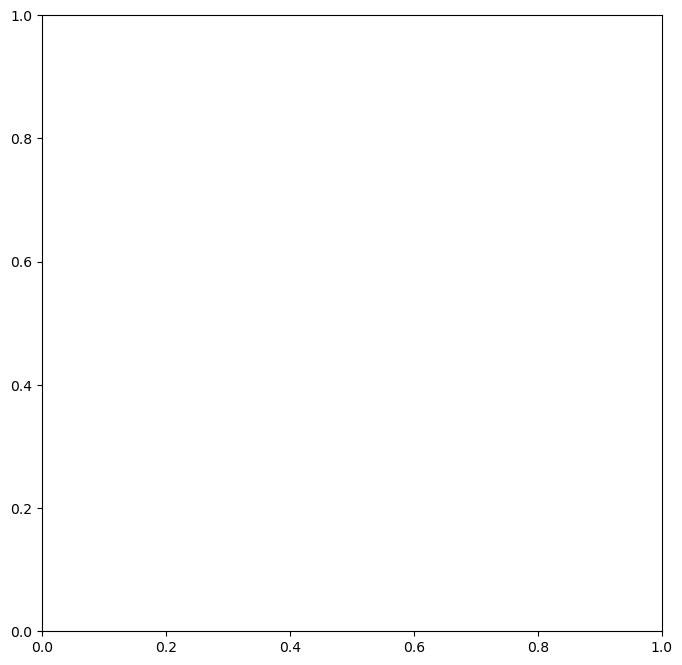

In [34]:
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

input = load(input_path + output_file)
# if not isinstance(input, dict):
#     input = dict(input)
for sel_accumulator in input:
    generate_plots(sel_accumulator, req_hists, req_plots, selections, stack, log, formats, plot_path, plot_props)

# yield_plot

# generate_plots(input, req_hists, req_plots, selections, stack, log, formats, plot_path, plot_props)

In [ ]:
 show_plots = [ ## plots to display
    'fourmuons_mass_log_stacked.png',
    'Z_res_mass_log_stacked.png',
    'Z_non_res_mass_log_stacked.png',
    'missing_p_log_stacked.png',
    'fourmuons_pmin_log_stacked.png',
    'vis_e_woMuons_log_stacked.png',
]
for sel in selections:
    sel_path = os.path.join(plot_path, sel)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(sel, fontsize=16)
    for ax, img_name in zip(axes.ravel(), show_plots):
        img_path = os.path.join(sel_path, img_name)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        # ax.set_title(img_name, fontsize=9)
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    plt.close('all')

In [ ]:
print(input[0]['sel0']['cutflow'].keys())
print(input[0]['sel0']['histograms'].keys())
# len(input["wzp6_ee_qqH_HZZ_llll_ecm240"]["sel1"]["histograms"]["selectedmuons_p"][0])
# print(input["wzp6_ee_qqH_HZZ_llll_ecm240"][1].keys())
# print(input.keys())



# print("Top-level input_dict type:", type(input))
# if isinstance(input, dict):
#     print("Keys:", list(input.keys()))
# else:
#     print("It's a tuple of length:", len(input))

# print("First element type:", type(input[0]))
# print(input[0])
# help(hist.Hist.fill)